In [1]:
import os
import sys
import pickle

PROJECT_ROOT = os.path.abspath('..')
sys.path.append(PROJECT_ROOT)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from tqdm import tqdm

from sleeprnn.helpers.reader import load_dataset
from sleeprnn.common import constants, viz, pkeys
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection.predicted_dataset import PredictedDataset
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import det_utils
from figs_thesis import fig_utils

viz.notebook_full_width()

param_filtering_fn = fig_utils.get_filtered_signal_for_event
param_frequency_fn = fig_utils.get_frequency_by_fft
param_amplitude_fn = fig_utils.get_amplitude_event

RESULTS_PATH = os.path.join(PROJECT_ROOT, 'results')

/home/ntapia/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Max amplitude preliminaries (MASS-KC)

In [ ]:
mass = load_dataset('mass_kc')
signals = mass.get_signals(normalize_clip=False)
marks = mass.get_stamps(pages_subset='n2')

In [ ]:
all_kc_min = []
all_kc_max = []
for sub_signal, sub_marks in zip(signals, marks):
    kc = [sub_signal[m[0]:m[1]+1] for m in sub_marks]
    kc_min = np.array([np.min(s) for s in kc])
    kc_max = np.array([np.max(s) for s in kc])
    all_kc_min.append(kc_min)
    all_kc_max.append(kc_max)
all_kc_min = np.concatenate(all_kc_min)
all_kc_max = np.concatenate(all_kc_max)
print(all_kc_min.shape, all_kc_max.shape)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=100)
ax = axes[0]
ax.hist(all_kc_min)
ax.set_title("Neg Peak")
ax = axes[1]
ax.hist(all_kc_max)
ax.set_title("Pos Peak")
plt.tight_layout()
plt.show()

prct = 98

print("Negative Peak prct %d: %1.4f uV" % (prct, np.percentile(all_kc_min, 100-prct)))
print("Positive Peak prct %d: %1.4f uV" % (prct, np.percentile(all_kc_max, prct)))

# Signal parameters preliminaries (MODA)

In [ ]:
moda = load_dataset('moda_ss')
signals = moda.get_signals(normalize_clip=False)
pages = moda.get_pages(pages_subset='n2')

moda_page_stats = {
    'scale': [],
    'exponent': [],
    'max_ratio': [],
    'standard_deviation': [],
    'r2': [],
}

for sub_signal, sub_pages in tqdm(zip(signals, pages)):
    sub_signal = sub_signal.reshape(-1, moda.fs * moda.page_duration)[sub_pages]  # [n_pages, n_samples]
    freq, pages_spectrum = utils.compute_pagewise_fft(sub_signal, moda.fs, window_duration=2)
    pages_scales, pages_exponents = utils.compute_pagewise_powerlaw(freq, pages_spectrum)  # (n_pages,)
    
    # Deviation from power law
    f_min = 2
    f_max = 30
    valid_locs = np.where((freq >= f_min) & (freq <= f_max))[0]
    dev_f = freq[valid_locs]
    dev_x = pages_spectrum[:, valid_locs]
    dev_x_law = [fit_s * (dev_f ** fit_e) for fit_s, fit_e in zip(pages_scales, pages_exponents)]
    dev_x_law = np.stack(dev_x_law, axis=0)
    error = dev_x / dev_x_law  # n_pages, n_freqs
    max_error = np.max(error, axis=1)  # to detect weird peaks, shape (n_pages,)
    
    # for r2, we remove sigma
    valid_locs = np.where((dev_f < 10) | (dev_f > 17))[0]
    dev_f = dev_f[valid_locs]
    log_dev_x = np.log(dev_x[:, valid_locs])
    log_dev_x_law = np.log(dev_x_law[:, valid_locs])
    squared_data = np.sum((log_dev_x - log_dev_x.mean(axis=1).reshape(-1, 1)) ** 2, axis=1)
    squared_residuals = np.sum((log_dev_x - log_dev_x_law) ** 2, axis=1)
    r2 = 1 - squared_residuals / squared_data  # (n_pages,)
    
    moda_page_stats['scale'].append(pages_scales)
    moda_page_stats['exponent'].append(pages_exponents)
    moda_page_stats['max_ratio'].append(max_error)
    moda_page_stats['standard_deviation'].append(sub_signal.std(axis=1))
    moda_page_stats['r2'].append(r2)

for key in moda_page_stats.keys():
    moda_page_stats[key] = np.concatenate(moda_page_stats[key])
    print(key, moda_page_stats[key].shape)

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(14, 4), dpi=120)
for i_k, key in enumerate(moda_page_stats.keys()):
    ax = axes[i_k]
    ax.hist(moda_page_stats[key], bins=20)
    ax.set_title('MODA\n%s. Min %1.4f Max %1.4f' % (key, moda_page_stats[key].min(), moda_page_stats[key].max()), fontsize=8)
    print(key, moda_page_stats[key].min(), moda_page_stats[key].max())
    ax.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

In [ ]:
moda = load_dataset('moda_ss')
signals = moda.get_signals(normalize_clip=False)
marks = moda.get_stamps(pages_subset='n2')

moda_page_stats = {
    'duration': [],
    'amplitude': [],
}

to_visualize = []

for sub_signal, sub_marks in tqdm(zip(signals, marks)):
    
    durations = (sub_marks[:, 1] - sub_marks[:, 0]) / moda.fs
    
    filt_signal = param_filtering_fn(sub_signal, moda.fs, constants.SPINDLE)
    signal_events = [filt_signal[e[0]:e[1]+1] for e in sub_marks]
    amplitudes = np.array([param_amplitude_fn(s, moda.fs, constants.SPINDLE) for s in signal_events])
    n_marks = durations.size
    for i in range(n_marks):
        if amplitudes[i] > 100:
            # visualize it, with 1 second context
            e = sub_marks[i]
            e[0] -= moda.fs 
            e[1] += moda.fs
            segment_signal = sub_signal[e[0]:e[1]+1]
            to_visualize.append(segment_signal)
    
    moda_page_stats['duration'].append(durations)
    moda_page_stats['amplitude'].append(amplitudes)

for key in moda_page_stats.keys():
    moda_page_stats[key] = np.concatenate(moda_page_stats[key])
    print(key, moda_page_stats[key].shape)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4), dpi=120)
for i_k, key in enumerate(moda_page_stats.keys()):
    ax = axes[i_k]
    ax.hist(moda_page_stats[key], bins=20)
    ax.set_title('MODA\n%s. Min %1.4f Max %1.4f' % (key, moda_page_stats[key].min(), moda_page_stats[key].max()), fontsize=8)
    print(key, moda_page_stats[key].min(), moda_page_stats[key].max())
    ax.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

In [ ]:
which_to_visualize = 0

segment_signal = to_visualize[which_to_visualize]
time_axis = np.arange(segment_signal.size) / moda.fs
mark_to_viz = np.array([moda.fs, segment_signal.size - moda.fs], dtype=np.int32)
filt_signal = param_filtering_fn(segment_signal, moda.fs, constants.SPINDLE)
spindle = filt_signal[mark_to_viz[0]:mark_to_viz[1]+1]
amplitude = param_amplitude_fn(spindle, moda.fs, constants.SPINDLE)

fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=120)
ax.plot(time_axis, segment_signal, linewidth=0.8)
ax.plot(mark_to_viz / moda.fs, [-75, -75], linewidth=3, color="r", alpha=0.5)
ax.set_ylim([-100, 100])
ax.set_title("amplitude %1.4f uV" % amplitude)
ax.grid()
plt.show()

# NSRR EXPLORATION

In [2]:
nsrr_preds = fig_utils.PredictedNSRR()

In [3]:
nsrr = load_dataset(constants.NSRR_SS_NAME, load_checkpoint=True, params={pkeys.PAGE_DURATION: 30})

Dataset nsrr_ss with 3 patients.
Loading from checkpoint... Loaded
Global STD: None
Dataset nsrr_ss with 11593 patients.


# Reproducción de tendencias

In [4]:
n_folds = 10

fold_ids_list = np.arange(n_folds)
# fold_ids_list = [3]
predictions = nsrr_preds.get_predictions(fold_ids_list, nsrr)

print("Loaded predictions for %d subjects" % (len(predictions.all_ids)))

Loaded predictions for 1000 subjects


In [5]:
min_n2_minutes = 60

subject_ids = predictions.all_ids

table_byevent = {
    'subject_id': [],
    'mark_id': [],
    'duration': [], 
    'amplitude': [],
    'sigma_to_beta': [],
    'entropy': [],
}
table_bysubject = {
    'subject_id': [], 
    'duration': [],
    'amplitude': [],
    'density': [], 
    'proba_event': [], 
    'n2_minutes': [], 
    'origin': [],
    'age': [], 
    'female': [],
    'pr_lacourse': [],
    'pl_exponent': [],
}
for i in range(len(subject_ids)):
    subject_id = subject_ids[i]
    n2_pages = predictions.data[subject_id]['n2_pages']
    n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
    
    if n2_minutes < min_n2_minutes:
        print("Skipped by N2 minutes: Subject %s with %d N2 minutes" % (subject_id, n2_minutes))
        continue
    
    marks = predictions.get_subject_stamps(subject_id)
    n_marks = marks.shape[0]
    
    if n_marks == 0:
        print("Zero Marks     : Subject %s with %d marks (%d N2 minutes)" % (subject_id, n_marks, n2_minutes))
        durations = np.zeros((0,), dtype=np.float32)
        subject_proba = np.zeros((0,), dtype=np.float32)
    else:
        durations = (marks[:, 1] - marks[:, 0] + 1) / nsrr.fs
        subject_proba = predictions.get_subject_stamps_probabilities(subject_id)

    subject_mean_duration = np.mean(durations)
    subject_density = n_marks / n2_minutes
    subject_mean_proba = np.mean(subject_proba)
    subdataset = subject_id[:-4]

    subject_data = nsrr.read_subject_data(subject_id, exclusion_of_pages=False)
    age = float(subject_data['age'].item())
    female = int(subject_data['sex'].item() == 'f')
    
    # Get signal mark stuff
    if n_marks == 0:
        amplitudes = np.zeros((0,), dtype=np.float32)
        sigma_to_beta = [np.nan]
        entropies = [np.nan]
    else:
        signal = subject_data['signal']
        filt_signal = param_filtering_fn(signal, nsrr.fs, constants.SPINDLE)
        signal_events = [filt_signal[e[0]:e[1]+1] for e in marks]
        amplitudes = np.array([param_amplitude_fn(s, nsrr.fs, constants.SPINDLE) for s in signal_events])
        
        # Sigma to beta (quality factor)
        spindles = [signal[e[0]:e[1]+1] for e in marks]
        sigma_to_beta = []
        entropies = []
        for sp in spindles:
            f, y = fig_utils.get_fft_spectrum(sp, nsrr.fs, pad_to_duration=10, f_min=1, f_max=30, apply_hann_window=False)
            this_sigma_to_beta = np.mean(y[(f >= 11) * (f <= 16)]) / np.mean(y[(f > 16) * (f <= 30)])
            sigma_to_beta.append(this_sigma_to_beta)
            
            spectrum_subset = y[(f >= 11) * (f <= 30)]
            spectrum_subset = spectrum_subset / spectrum_subset.sum()
            spectrum_subset = spectrum_subset.astype(np.float64)
            entropy = np.sum(-spectrum_subset * np.log(spectrum_subset + 1e-6))
            entropies.append(entropy)
            
        
    subject_mean_amplitude = np.mean(amplitudes)
    
    if n_marks == 0:
        marks_id = [-1]
        subject_ids_to_append = [subject_id]
        durations = [np.nan]
        amplitudes = [np.nan]
    else:
        marks_id = np.arange(durations.size)
        subject_ids_to_append = [subject_id] * durations.size
        
    signal = subject_data['signal']
    signal_n2 = signal.reshape(-1, nsrr.fs * nsrr.original_page_duration)[n2_pages].flatten()
    freq, power = utils.power_spectrum_by_sliding_window(signal_n2, nsrr.fs, window_duration=5)
    # Measure sigma peak ratio 
    sigma_power = power[(freq >= 11) & (freq <= 16)].mean()
    broad_power = power[(freq >= 4.5) & (freq <= 30)].mean()
    pr_lacourse = sigma_power / broad_power
    # Measure power law exponent
    locs_to_use = np.where(((freq >= 2) & (freq < 10)) | ((freq > 17) & (freq <= 30)))[0]
    x_data = freq[locs_to_use]
    y_data = power[locs_to_use]
    log_x = np.log(x_data)
    log_y = np.log(y_data)
    pl_exponent, _, _, _, _ = scipy.stats.linregress(log_x, log_y)
    
    # Save
    table_byevent['duration'].append(durations)
    table_byevent['amplitude'].append(amplitudes)
    table_byevent['subject_id'].append(subject_ids_to_append)
    table_byevent['mark_id'].append(marks_id)
    table_byevent['sigma_to_beta'].append(sigma_to_beta)
    table_byevent['entropy'].append(entropies)
    
    table_bysubject['subject_id'].append(subject_id)
    table_bysubject['duration'].append(subject_mean_duration)
    table_bysubject['amplitude'].append(subject_mean_amplitude)
    table_bysubject['density'].append(subject_density)
    table_bysubject['proba_event'].append(subject_mean_proba)
    table_bysubject['n2_minutes'].append(n2_minutes)
    table_bysubject['origin'].append(subdataset)
    table_bysubject['age'].append(age)
    table_bysubject['female'].append(female)
    table_bysubject['pr_lacourse'].append(pr_lacourse)
    table_bysubject['pl_exponent'].append(pl_exponent)
    
for key in table_byevent:
    table_byevent[key] = np.concatenate(table_byevent[key])
table_byevent = pd.DataFrame.from_dict(table_byevent)
table_bysubject = pd.DataFrame.from_dict(table_bysubject)
print("Done.")

Skipped by N2 minutes: Subject cfs-visit5-800280 with 13 N2 minutes
Skipped by N2 minutes: Subject cfs-visit5-800393 with 1 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-300365 with 0 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-300805 with 47 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-300915 with 36 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-301091 with 32 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-301108 with 53 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-nonrandomized-300060 with 56 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-nonrandomized-300521 with 0 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-nonrandomized-300607 with 0 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-nonrandomized-300775 with 49 N2 minutes
Skipped by N2 minutes: Subject mros-visit1-aa0121 with 9 N2 minutes
Skipped by N2 minutes: Subject mros-visit1-aa0965 with 15 N2 minutes
Skipped by N2 minutes: Subject mros-

/home/ntapia/miniconda3/envs/tf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ntapia/miniconda3/envs/tf/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Skipped by N2 minutes: Subject shhs1-201581 with 0 N2 minutes
Skipped by N2 minutes: Subject shhs1-201711 with 0 N2 minutes
Skipped by N2 minutes: Subject shhs1-201788 with 28 N2 minutes
Skipped by N2 minutes: Subject shhs1-202005 with 20 N2 minutes
Skipped by N2 minutes: Subject shhs1-202274 with 59 N2 minutes
Skipped by N2 minutes: Subject shhs1-202418 with 0 N2 minutes
Skipped by N2 minutes: Subject shhs1-202444 with 37 N2 minutes
Skipped by N2 minutes: Subject shhs1-202456 with 0 N2 minutes
Skipped by N2 minutes: Subject shhs1-202519 with 0 N2 minutes
Skipped by N2 minutes: Subject shhs1-202616 with 28 N2 minutes
Skipped by N2 minutes: Subject shhs1-203313 with 50 N2 minutes
Skipped by N2 minutes: Subject shhs1-203474 with 39 N2 minutes
Skipped by N2 minutes: Subject shhs1-203643 with 0 N2 minutes
Skipped by N2 minutes: Subject shhs1-205404 with 0 N2 minutes
Skipped by N2 minutes: Subject shhs1-205483 with 57 N2 minutes
Skipped by N2 minutes: Subject shhs1-205545 with 20 N2 minutes

In [6]:
table_byevent

,subject_id,mark_id,duration,amplitude,sigma_to_beta,entropy
0,ccshs-trec-1800034,0,0.44,24.371809,4.515578,4.850695
1,ccshs-trec-1800034,1,0.72,28.900696,4.275740,4.856860
2,ccshs-trec-1800034,2,1.48,23.536839,0.421026,5.082756
3,ccshs-trec-1800034,3,0.60,26.453024,6.213959,4.745415
4,ccshs-trec-1800034,4,0.64,68.478527,7.569849,4.570531
...,...,...,...,...,...,...
192516,sof-visit-8-09666,32,0.40,23.096822,4.093372,4.801654
192517,sof-visit-8-09666,33,0.68,30.118468,3.218246,4.884056
192518,sof-visit-8-09666,34,0.36,26.908962,4.793505,4.830603
192519,sof-visit-8-09666,35,0.84,25.503003,6.211208,4.731753


In [7]:
table_bysubject

,subject_id,duration,amplitude,density,proba_event,n2_minutes,origin,age,female,pr_lacourse,pl_exponent
0,ccshs-trec-1800034,1.116099,46.538635,4.969325,0.924815,163.0,ccshs-trec-180,17.40,1,1.859941,-1.279945
1,ccshs-trec-1800038,1.102703,39.584287,4.422989,0.884689,217.5,ccshs-trec-180,17.40,1,1.510728,-1.136783
2,ccshs-trec-1800065,0.955740,31.335450,3.038202,0.883258,222.5,ccshs-trec-180,17.68,1,1.522630,-1.228495
3,ccshs-trec-1800074,0.874654,40.135913,2.901869,0.874962,214.0,ccshs-trec-180,17.86,1,1.389635,-1.336513
4,ccshs-trec-1800078,0.834952,32.414402,2.630252,0.856754,238.0,ccshs-trec-180,17.77,0,1.328701,-1.223523
...,...,...,...,...,...,...,...,...,...,...,...
959,sof-visit-8-09018,0.717977,29.631529,1.266010,0.871988,203.0,sof-visit-8-0,81.00,1,1.184157,-1.137382
960,sof-visit-8-09036,0.728224,29.692975,0.924406,0.849786,231.5,sof-visit-8-0,81.00,1,1.160043,-1.204618
961,sof-visit-8-09614,0.948444,39.849900,0.497238,0.725876,90.5,sof-visit-8-0,83.00,1,1.132153,-1.082930
962,sof-visit-8-09627,0.699478,34.449030,1.079812,0.788725,106.5,sof-visit-8-0,82.00,1,1.140398,-1.177473


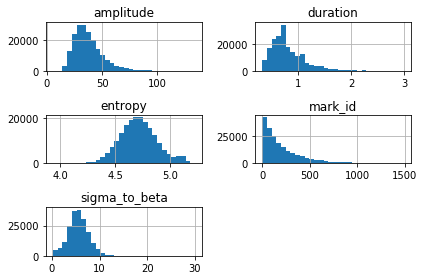

In [8]:
# by-event stuff
table_byevent.hist(bins=30)
plt.tight_layout()
plt.show()

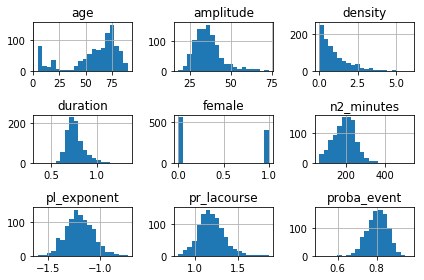

In [9]:
# by-subject stuff
table_bysubject.hist(bins=20)
plt.tight_layout()
plt.show()

# Check tendencies

In [ ]:
a = (table_bysubject['n2_minutes'] * table_bysubject['density'])
a[a <= 20].hist(bins=np.arange(0, 20 + 0.001, 1))
plt.show()
print(a.min())

In [ ]:
zoom_density = 0.5

table_zoom = table_bysubject[table_bysubject.density < zoom_density]
table_zoom.hist()
plt.tight_layout()
plt.show()

In [ ]:
# correlations

param_names = table_bysubject.select_dtypes(include=np.number).columns.tolist()
n_params = len(param_names)
n_plots = n_params * (n_params - 1) / 2
n_cols = 5
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows* 2.5), dpi=100)
axes = axes.flatten()
global_count = -1
for i in range(n_params):
    for j in range(i + 1, n_params):
        global_count += 1
        ax = axes[global_count]
        
        x_data = table_bysubject[param_names[i]].values
        y_data = table_bysubject[param_names[j]].values
        
        ax.plot(x_data, y_data, linestyle="none", marker='o', markersize=3, alpha=0.1)
        ax.set_xlabel(param_names[i], fontsize=8)
        ax.set_ylabel(param_names[j], fontsize=8)
        
        ax.tick_params(labelsize=8)
        ax.grid()
plt.tight_layout()
plt.show()

In [ ]:
table_bysubject[table_bysubject.duration > 1.2]

# Check by-event anomalies

In [ ]:
# poor spindles
subtable = table_byevent[table_byevent.sigma_to_beta < 2]

unique_subjects = np.unique(subtable.subject_id)
print("Unique subjects:", len(unique_subjects))
subtable.sort_values(by=["sigma_to_beta"], ascending=True)

In [ ]:
subtable.sigma_to_beta.hist()

In [ ]:
# too long spindles
subtable = table_byevent[table_byevent.duration > 2.95]

unique_subjects = np.unique(subtable.subject_id)
print("Unique subjects:", len(unique_subjects))
subtable.sort_values(by=["amplitude"], ascending=False)

In [ ]:
subtable.duration.hist()

In [ ]:
# weird amplitudes
cutoff = 0.1

bottom_thr, upper_thr = np.percentile(table_byevent.amplitude.dropna().values, (cutoff, 100 - cutoff))
print("Top %s%% PP amplitudes are larger than %1.4f uV" % (cutoff, upper_thr))
print("Bottom %s%% PP amplitudes are smaller than %1.4f uV" % (cutoff, bottom_thr))

In [ ]:
# too small spindles
subtable = table_byevent[table_byevent.amplitude < 10]

unique_subjects = np.unique(subtable.subject_id)
print("Unique subjects:", len(unique_subjects))
subtable.sort_values(by=["amplitude"], ascending=True)

In [ ]:
subtable.amplitude.hist()

In [ ]:
# too large spindles
subtable = table_byevent[table_byevent.amplitude > 200]

unique_subjects = np.unique(subtable.subject_id)
print("Unique subjects:", len(unique_subjects))
subtable.sort_values(by=["amplitude"], ascending=False)

In [ ]:
subtable.amplitude.hist()

In [10]:
# too large spindles according to MODA stats (max encountered in entire MODA dataset)
subtable = table_byevent[table_byevent.amplitude > 134.12087769782073]

unique_subjects = np.unique(subtable.subject_id)
print("Unique subjects:", len(unique_subjects))
subtable.sort_values(by=["amplitude"], ascending=False)

Unique subjects: 0


,subject_id,mark_id,duration,amplitude,sigma_to_beta,entropy


Fraction of events affected: 0.0000%


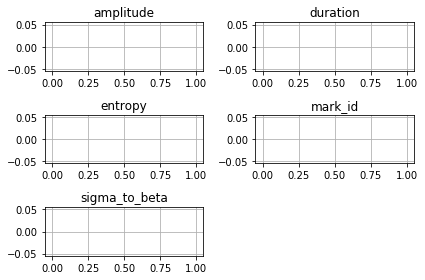

In [11]:
# fraction of spindles in this situation:
n_outliers = len(subtable)
n_total = len(table_byevent)
fraction_outliers = 100 * n_outliers / n_total
print("Fraction of events affected: %1.4f%%" % fraction_outliers)

subtable.hist()
plt.tight_layout()
plt.show()

In [ ]:
table_byevent.hist()
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(8, 3), dpi=200)
table_byevent.drop(columns=["mark_id"]).hist(ax=axes[0, :], bins=30)
subtable.drop(columns=["mark_id"]).hist(ax=axes[1, :], bins=10)

axes[0, 0].set_xlim([0, 300])
axes[1, 0].set_xlim([0, 300])

axes[0, 1].set_xlim([0, 3])
axes[1, 1].set_xlim([0, 3])

axes[0, 2].set_xlim([3.5, 5.5])
axes[1, 2].set_xlim([3.5, 5.5])

axes[0, 3].set_xlim([0, 30])
axes[1, 3].set_xlim([0, 30])

for ax in axes.flatten():
    ax.tick_params(labelsize=8)

axes[0, 0].set_title("Amplitud PP ($\mu$V)", fontsize=9)
axes[1, 0].set_title("Amplitud PP ($\mu$V)\n(anómalos)", fontsize=9)

axes[0, 1].set_title("Duración (s)", fontsize=9)
axes[1, 1].set_title("Duración (s)\n(anómalos)", fontsize=9)

axes[0, 2].set_title("Entropía 11-30 Hz", fontsize=9)
axes[1, 2].set_title("Entropía 11-30 Hz\n(anómalos)", fontsize=9)

axes[0, 3].set_title("Razón sigma:beta", fontsize=9)
axes[1, 3].set_title("Razón sigma:beta\n(anómalos)", fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
subtable = table_byevent[table_byevent.amplitude <= 134.12087769782073]
subtable.hist(bins=30)
plt.tight_layout()
plt.show()

# Check by-subject anomalies

In [18]:
# Check subjects with abnormal densities
# MODA by-subject ranges (N=28)
# Duration: 0.55 - 0.96 s aprox
# Density: 0.8 - 8.7 epm aprox (if we count that subject with 2 events then the min is 0.1 epm)
# Amplitude: 20 - 44 uV aprox
# Frequency: 11.5 - 13.9 Hz aprox

moda = load_dataset('moda_ss')
subject_ids = moda.all_ids # [sub_id for sub_id in moda.all_ids if moda.data[sub_id]['n_blocks'] == 10]

moda_table_bysubject = {
    'subject_id': [],
    'density': [],
    'pr_lacourse': [],
    'pl_exponent': [],
    # 'duration': [],
    # 'amplitude': [],
    # 'frequency': [],
}

for subject_id in subject_ids:
    signal = moda.get_subject_signal(subject_id, normalize_clip=False)
    marks = moda.get_subject_stamps(subject_id, pages_subset='n2')
    n2_pages = moda.get_subject_pages(subject_id, pages_subset='n2')
    n2_minutes = n2_pages.shape[0] * moda.page_duration / 60
    density = marks.shape[0] / n2_minutes
    
    signal_n2 = signal.reshape(-1, moda.page_size)[n2_pages].flatten()
    freq, power = utils.power_spectrum_by_sliding_window(signal_n2, moda.fs, window_duration=5)
    # Measure sigma peak ratio 
    sigma_power = power[(freq >= 11) & (freq <= 16)].mean()
    broad_power = power[(freq >= 4.5) & (freq <= 30)].mean()
    pr_lacourse = sigma_power / broad_power
    # Measure power law exponent
    locs_to_use = np.where(((freq >= 2) & (freq < 10)) | ((freq > 17) & (freq <= 30)))[0]
    x_data = freq[locs_to_use]
    y_data = power[locs_to_use]
    log_x = np.log(x_data)
    log_y = np.log(y_data)
    pl_exponent, _, _, _, _ = scipy.stats.linregress(log_x, log_y)
    
    moda_table_bysubject['subject_id'].append(subject_id)
    moda_table_bysubject['density'].append(density)
    moda_table_bysubject['pr_lacourse'].append(pr_lacourse)
    moda_table_bysubject['pl_exponent'].append(pl_exponent)

moda_table_bysubject = pd.DataFrame.from_dict(moda_table_bysubject)
# moda_table_bysubject.sort_values(by=["density"])

Dataset moda_ss with 180 patients.
Loading from checkpoint... Loaded
Global STD: None


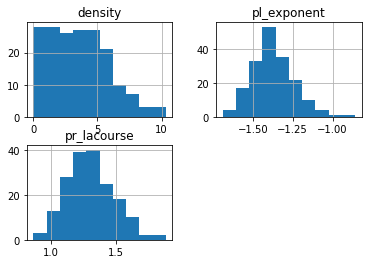

-1.690019848399457
-0.8588008063229291


In [21]:
moda_table_bysubject.hist()
plt.show()

print(moda_table_bysubject.pl_exponent.min())
print(moda_table_bysubject.pl_exponent.max())

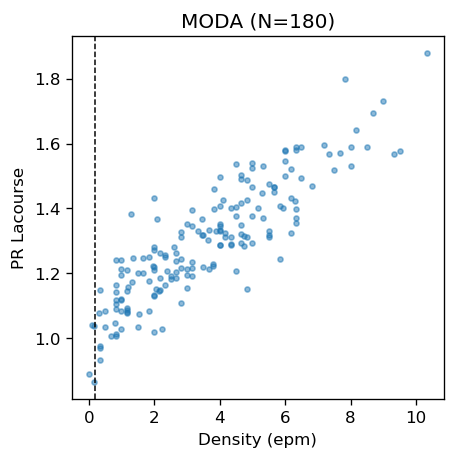

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=120)
ax.plot(
    moda_table_bysubject.density.values, 
    moda_table_bysubject.pr_lacourse.values,
    markersize=3,
    marker='o',
    linestyle="none", 
    alpha=0.5)
ax.axvline(0.2, linewidth=0.9, color="k", linestyle="--")
ax.set_xlabel("Density (epm)")
ax.set_ylabel("PR Lacourse")
ax.set_title("MODA (N=%d)" % len(moda_table_bysubject.density.values))
plt.show()

In [16]:
def simulated_mean_power(pl_exponent, freq_low, freq_high):
    if pl_exponent == -1:
        sum_term = np.log(freq_high / freq_low)
    else:
        sum_term = (freq_high ** (pl_exponent + 1) - freq_low ** (pl_exponent + 1))
    return sum_term / (freq_high - freq_low)

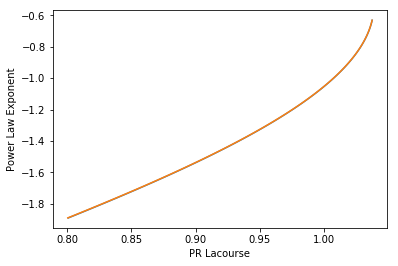

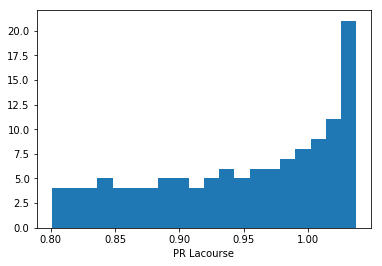

In [17]:
# simulated PR Lacourse when no sigma peak exists
moda_power_law_exponent_min = -1.8909820062793914  # <- these are by-page values, not by-subject values
moda_power_law_exponent_max = -0.6304845212942357
pl_exponent_l = np.arange(moda_power_law_exponent_min, moda_power_law_exponent_max + 0.001, 0.01)
ratio_l = []
ratio_l_theo = []
for pl_exponent in pl_exponent_l:
    freq = np.arange(0.1, 30 + 0.001, 0.01)
    power = freq ** pl_exponent
    # Measure sigma peak ratio 
    sigma_power = power[(freq >= 11) & (freq <= 16)].mean()
    broad_power = power[(freq >= 4.5) & (freq <= 30)].mean()
    pr_lacourse = sigma_power / broad_power
    pr_lacourse_theo = simulated_mean_power(pl_exponent, 11, 16) / simulated_mean_power(pl_exponent, 4.5, 30)
    ratio_l.append(pr_lacourse)
    ratio_l_theo.append(pr_lacourse_theo)

plt.plot(ratio_l, pl_exponent_l)
plt.plot(ratio_l_theo, pl_exponent_l)
plt.xlabel("PR Lacourse")
plt.ylabel("Power Law Exponent")
plt.show()

plt.hist(ratio_l, bins=20)
plt.xlabel("PR Lacourse")

plt.show()

95.0207 % subjects with at least 13 detections


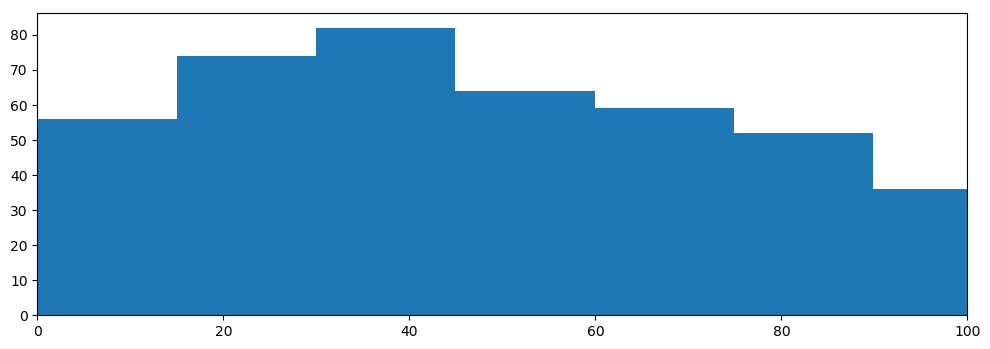

In [62]:
n_detections = table_bysubject.density.values * table_bysubject.n2_minutes.values

min_n_detections = int(np.percentile(n_detections, 5))
fraction_inliers = 100 * (n_detections >= min_n_detections).mean()
print("%1.4f %% subjects with at least %d detections" % (fraction_inliers, min_n_detections))

fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=100)
ax.hist(n_detections, bins=100)
ax.set_xlim([0, 100])
plt.show()

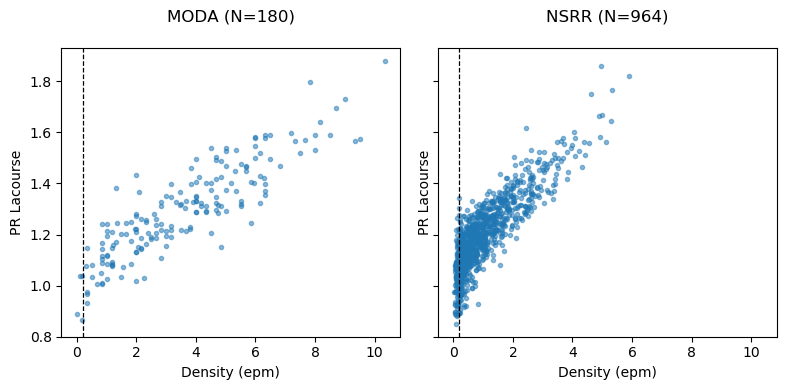

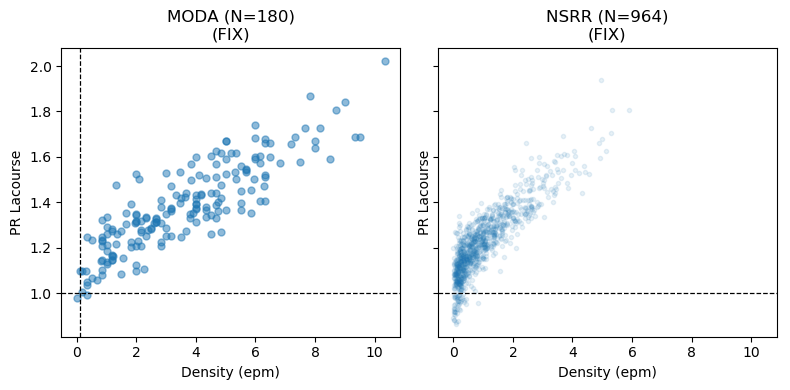

In [42]:
# now nsrr
min_n_detections = 10
n_detections = table_bysubject.density.values * table_bysubject.n2_minutes.values
valids_bysubject = (n_detections > min_n_detections)


fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=100, sharex=True, sharey=True)
ax = axes[0]

pr_raw = moda_table_bysubject.pr_lacourse.values
pr_flat_sim = np.array([
    simulated_mean_power(pl_exponent, 11, 16) / simulated_mean_power(pl_exponent, 4.5, 30)
    for pl_exponent in moda_table_bysubject.pl_exponent.values
])
pr_corrected = pr_raw / pr_flat_sim

ax.plot(
    moda_table_bysubject.density.values, 
    pr_raw,
    markersize=3,
    marker='o',
    linestyle="none", 
    alpha=0.5)
ax.axvline(0.2, linewidth=0.9, color="k", linestyle="--")
ax.set_xlabel("Density (epm)")
ax.set_ylabel("PR Lacourse")
ax.set_title("MODA (N=%d)\n" % len(moda_table_bysubject.density.values))

ax = axes[1]

pr_raw = table_bysubject.pr_lacourse.values
pr_flat_sim = np.array([
    simulated_mean_power(pl_exponent, 11, 16) / simulated_mean_power(pl_exponent, 4.5, 30)
    for pl_exponent in table_bysubject.pl_exponent.values
])
pr_corrected = pr_raw / pr_flat_sim

ax.plot(
    table_bysubject.density.values[valids_bysubject], 
    pr_raw[valids_bysubject],
    markersize=3,
    marker='o',
    linestyle="none", 
    alpha=0.5)
ax.axvline(0.2, linewidth=0.9, color="k", linestyle="--")
ax.set_xlabel("Density (epm)")
ax.set_ylabel("PR Lacourse")
ax.set_title("NSRR (N=%d)\n" % len(table_bysubject.density.values))
plt.tight_layout()
plt.show()

# now nsrr
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=100, sharex=True, sharey=True)
ax = axes[0]

pr_raw = moda_table_bysubject.pr_lacourse.values
pr_flat_sim = np.array([
    simulated_mean_power(pl_exponent, 11, 16) / simulated_mean_power(pl_exponent, 4.5, 30)
    for pl_exponent in moda_table_bysubject.pl_exponent.values
])
pr_corrected = pr_raw / pr_flat_sim

ax.plot(
    moda_table_bysubject.density.values, 
    pr_corrected,
    markersize=5,
    marker='o',
    linestyle="none", 
    alpha=0.5)
ax.axvline(0.1, linewidth=0.9, color="k", linestyle="--")
ax.axhline(1.0, linewidth=0.9, color="k", linestyle="--")
ax.set_xlabel("Density (epm)")
ax.set_ylabel("PR Lacourse")
ax.set_title("MODA (N=%d)\n(FIX)" % len(moda_table_bysubject.density.values))

ax = axes[1]

pr_raw = table_bysubject.pr_lacourse.values
pr_flat_sim = np.array([
    simulated_mean_power(pl_exponent, 11, 16) / simulated_mean_power(pl_exponent, 4.5, 30)
    for pl_exponent in table_bysubject.pl_exponent.values
])
pr_corrected = pr_raw / pr_flat_sim

ax.plot(
    table_bysubject.density.values,#[valids_bysubject], 
    pr_corrected,#[valids_bysubject],
    markersize=3,
    marker='o',
    linestyle="none", 
    alpha=0.1)
#ax.axvline(0.1, linewidth=0.9, color="k", linestyle="--")
ax.axhline(1.0, linewidth=0.9, color="k", linestyle="--")
ax.set_xlabel("Density (epm)")
ax.set_ylabel("PR Lacourse")
ax.set_title("NSRR (N=%d)\n(FIX)" % len(table_bysubject.density.values))

#ax.set_xlim([0, 2])

plt.tight_layout()
plt.show()

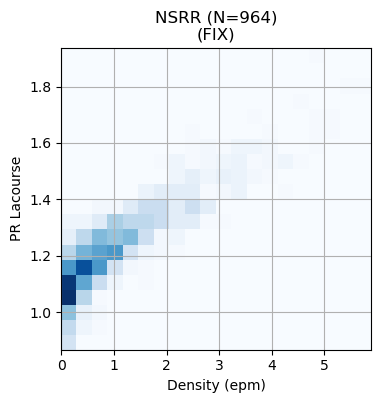

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=100)
pr_raw = table_bysubject.pr_lacourse.values
pr_flat_sim = np.array([
    simulated_mean_power(pl_exponent, 11, 16) / simulated_mean_power(pl_exponent, 4.5, 30)
    for pl_exponent in table_bysubject.pl_exponent.values
])
pr_corrected = pr_raw / pr_flat_sim

#ax.plot(
#    table_bysubject.density.values,#[valids_bysubject], 
#    pr_corrected,#[valids_bysubject],
#    markersize=3,
#    marker='o',
#    linestyle="none", 
#    alpha=0.1)
ax.hist2d(
    table_bysubject.density.values,
    pr_corrected,
    bins=20,
    cmap='Blues',
)
#ax.axvline(0.1, linewidth=0.9, color="k", linestyle="--")
#ax.axhline(1.0, linewidth=0.9, color="k", linestyle="--")
ax.set_xlabel("Density (epm)")
ax.set_ylabel("PR Lacourse")
ax.set_title("NSRR (N=%d)\n(FIX)" % len(table_bysubject.density.values))
ax.grid()
plt.show()

# Check stats of all pages

In [ ]:
page_stats = {
    'scale': [],
    'exponent': [],
    'max_ratio': [],
    'standard_deviation': [],
    'r2': [],
}

for subject_id in tqdm(predictions.all_ids):
    subject_data = nsrr.read_subject_data(subject_id, exclusion_of_pages=False)
    sub_signal = subject_data['signal']
    sub_pages = predictions.data[subject_id]['n2_pages']
    
    n2_minutes = sub_pages.size * nsrr.original_page_duration / 60
    if n2_minutes < 60:
        continue
    
    sub_signal = sub_signal.reshape(-1, nsrr.fs * nsrr.original_page_duration)[sub_pages]  # [n_pages, n_samples]
    freq, pages_spectrum = utils.compute_pagewise_fft(sub_signal, nsrr.fs, window_duration=2)
    pages_scales, pages_exponents = utils.compute_pagewise_powerlaw(freq, pages_spectrum)  # (n_pages,)
    
    # Deviation from power law
    f_min = 2
    f_max = 30
    valid_locs = np.where((freq >= f_min) & (freq <= f_max))[0]
    dev_f = freq[valid_locs]
    dev_x = pages_spectrum[:, valid_locs]
    dev_x_law = [fit_s * (dev_f ** fit_e) for fit_s, fit_e in zip(pages_scales, pages_exponents)]
    dev_x_law = np.stack(dev_x_law, axis=0)
    error = dev_x / dev_x_law  # n_pages, n_freqs
    max_error = np.max(error, axis=1)  # to detect weird peaks, shape (n_pages,)
    
    # for r2, we remove sigma
    valid_locs = np.where((dev_f < 10) | (dev_f > 17))[0]
    dev_f = dev_f[valid_locs]
    log_dev_x = np.log(dev_x[:, valid_locs])
    log_dev_x_law = np.log(dev_x_law[:, valid_locs])
    squared_data = np.sum((log_dev_x - log_dev_x.mean(axis=1).reshape(-1, 1)) ** 2, axis=1)
    squared_residuals = np.sum((log_dev_x - log_dev_x_law) ** 2, axis=1)
    r2 = 1 - squared_residuals / squared_data  # (n_pages,)
    
    page_stats['scale'].append(pages_scales)
    page_stats['exponent'].append(pages_exponents)
    page_stats['max_ratio'].append(max_error)
    page_stats['standard_deviation'].append(sub_signal.std(axis=1))
    page_stats['r2'].append(r2)

for key in page_stats.keys():
    page_stats[key] = np.concatenate(page_stats[key])
    print(key, page_stats[key].shape)

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(14, 4), dpi=120)
for i_k, key in enumerate(page_stats.keys()):
    ax = axes[i_k]
    
    value_vector = page_stats[key]
    moda_value_vector = moda_page_stats[key]
    
    if key in ['scale', 'max_ratio', 'standard_deviation']:
        value_vector = np.log(value_vector)
        moda_value_vector = np.log(moda_value_vector)
        name_str = 'log %s' % key
    else:
        name_str = key
        
    moda_min = moda_value_vector.min()
    moda_max = moda_value_vector.max()
    
    # Count number of pages falling outside MODA ranges
    n_inliers = np.sum((value_vector >= moda_min) * (value_vector <= moda_max))
    n_total = value_vector.size
    fraction_inliers = 100 * n_inliers / n_total
    
    ax.hist(value_vector, bins=50)
    ax.set_title('NSRR\n%s\nMin %1.4f Max %1.4f\n(MODA Min %1.4f Max %1.4f)\nInliers: %1.2f%%' % (
        name_str, value_vector.min(), value_vector.max(), moda_min, moda_max, fraction_inliers), fontsize=8)
    ax.tick_params(labelsize=8)
    ax.axvline(moda_min, color="k", linestyle="--", linewidth=0.8)
    ax.axvline(moda_max, color="k", linestyle="--", linewidth=0.8)
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
spectra = []
all_std = []
large_subjects = []
origin_subject_id = []
origin_page_id = []
for subject_id in predictions.all_ids:
    signal = nsrr.get_subject_signal(subject_id, normalize_clip=False)
    n2_pages = predictions.data[subject_id]['n2_pages']
    n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
    
    if n2_minutes < 60:
        continue
    
    x_pages = signal.reshape(-1, nsrr.original_page_duration * nsrr.fs)[n2_pages]
    for i_n2, x in enumerate(x_pages):
        freq, power = utils.power_spectrum_by_sliding_window(x, nsrr.fs, window_duration=2)
        spectra.append(power)
        this_std = x.std()
        all_std.append(this_std)
        origin_subject_id.append(subject_id)
        origin_page_id.append(n2_pages[i_n2])
        if this_std > 50:
            large_subjects.append(subject_id)
spectra = np.stack(spectra, axis=0)
all_std = np.array(all_std)
large_subjects = np.unique(large_subjects)
origin_subject_id = np.array(origin_subject_id)
origin_page_id = np.array(origin_page_id)
print("Done")
print(spectra.shape, all_std.shape, large_subjects.shape)

In [ ]:
# std hist
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=100)
ax.hist(all_std, bins=np.arange(0, 130 + 0.001, 2.5))
ax.set_xticks(np.arange(0, 130 + 0.001, 10))
ax.grid()
plt.show()

print("STD -- Min %1.4f, Mean %1.4f, Median %1.4f, Max %1.4f" % (all_std.min(), all_std.mean(), np.median(all_std), all_std.max()))

# Central 95% of pages
# STD between 7.5 and 36.
# Central 99% of pages
# STD between 6.15 and 73.34

prctl = 0.5
print("STD -- Percentile %s: %1.4f" % (prctl, np.percentile(all_std, prctl)))

prctl = 99.5
print("STD -- Percentile %s: %1.4f" % (prctl, np.percentile(all_std, prctl)))
print(np.sum(all_std > 50), all_std.size, 100 * np.sum(all_std > 50)/all_std.size)

In [ ]:
valid_locs = np.where((freq >= 0.3) & (freq <= 30))[0]
freq_short = freq[valid_locs]
spectra_short = spectra[:, valid_locs]

# Compute power law
locs_to_use = np.where(freq_short >= 4)[0]
x_data = freq_short[locs_to_use]
y_data = spectra_short[350, locs_to_use]

locs_no_sigma = np.where((x_data < 10) | (x_data > 17))[0]
x_data_no_sigma = x_data[locs_no_sigma]
y_data_no_sigma = y_data[locs_no_sigma]

log_x = np.log(x_data_no_sigma)
log_y = np.log(y_data_no_sigma)
pl_exponent, pl_intercept, _, _, _ = scipy.stats.linregress(log_x,log_y)
def fitted_power_law(x):
    return (x ** pl_exponent) * np.exp(pl_intercept)
print(pl_exponent, pl_intercept)

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=140)

ax = axes[0]
ax.plot(x_data, y_data, linewidth=0.8)
ax.plot(x_data_no_sigma, y_data_no_sigma, linewidth=0.8)
ax.plot(x_data, fitted_power_law(x_data), linewidth=0.8)
ax.set_xlim([3, 35])
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)

ax = axes[1]
ax.plot(x_data, y_data, linewidth=0.8)
ax.plot(x_data_no_sigma, y_data_no_sigma, linewidth=0.8)
ax.plot(x_data, fitted_power_law(x_data), linewidth=0.8)
ax.set_xlim([3, 35])
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
exponent_list = []
for curve in spectra_short:
    #Compute power law
    locs_to_use = np.where(freq_short >= 4)[0]
    x_data = freq_short[locs_to_use]
    y_data = curve[locs_to_use]

    locs_no_sigma = np.where((x_data < 10) | (x_data > 17))[0]
    x_data_no_sigma = x_data[locs_no_sigma]
    y_data_no_sigma = y_data[locs_no_sigma]
    # Therefore we are considering frequencies 4-10 and 17-30 Hz for the power law.

    log_x = np.log(x_data_no_sigma)
    log_y = np.log(y_data_no_sigma)
    pl_exponent, pl_intercept, _, _, _ = scipy.stats.linregress(log_x,log_y)
    exponent_list.append(pl_exponent)
exponent_list = np.array(exponent_list)

In [ ]:
exponent_list.shape

In [ ]:
mean_val = np.median(exponent_list)
disp_val = scipy.stats.median_absolute_deviation(exponent_list)  # dispersion around median
disp_width = 2.2

lower_bound = mean_val - disp_width * disp_val
upper_bound = mean_val + disp_width * disp_val

n_inliers = np.sum((exponent_list >= lower_bound) * (exponent_list <= upper_bound))
print(n_inliers, 100 * n_inliers / exponent_list.size)
print(lower_bound, upper_bound)
print("")

fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=120)
ax.hist(exponent_list, bins=50)
ax.axvline(mean_val, color="k", linestyle="--", linewidth=1)
ax.axvline(upper_bound, color="k", linestyle="--", linewidth=1)
ax.axvline(lower_bound, color="k", linestyle="--", linewidth=1)
ax.set_title("Mean %1.4f" % mean_val)
plt.show()

for prct in [0, 0.5, 5, 95, 99.5, 100]:
    value = np.percentile(exponent_list, prct)
    print("Percentile %s is %1.4f" % (prct, value))

In [ ]:
valid_locs = np.where((freq >= 0.3) & (freq <= 30))[0]
freq_short = freq[valid_locs]
spectra_short = spectra[:, valid_locs]

# Compute avg power of 2Hz freq bands
all_p_avg = []
all_f_avg = []
start_freq = 0
width = 2
n_bands = int(np.ceil((freq_short.max() - start_freq) / width))
for i_band in range(n_bands):
    end_freq = start_freq + width
    locs = np.where((f >= start_freq) & (f < end_freq))[0]
    center_freq = (start_freq + end_freq)/2
    start_freq = end_freq
    if center_freq < 2:
        continue
    this_power = spectra_short[:, locs].mean(axis=1)
    all_p_avg.append(this_power)
    all_f_avg.append(center_freq)
    
all_f_avg = np.array(all_f_avg)
all_p_avg = np.stack(all_p_avg, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=200)

ax = axes[0]
prctl_results = np.percentile(all_p_avg, (0, 0.5, 25, 50, 75, 99.5, 100), axis=0)
for curve in prctl_results:
    ax.plot(all_f_avg, curve, linewidth=0.8, marker='o')
ax.set_xlim([0.1, 35])
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)

ax = axes[1]
for curve in prctl_results:
    ax.plot(all_f_avg, curve, linewidth=0.8, marker='o')
ax.set_xlim([0.1, 35])
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
valid_locs = np.where((freq >= 0.3) & (freq <= 30))[0]
freq_short = freq[valid_locs]
spectra_short = spectra[:, valid_locs]

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=200)

prctl_results = np.percentile(all_p_avg, (0.5, 99.5), axis=0)

ax = axes[0]
for curve in prctl_results:
    ax.plot(all_f_avg, curve, linewidth=0.8, marker='o', markersize=3, color="b")
for curve in spectra_short[outliers_locs]:
    ax.plot(freq_short, curve, linewidth=0.8, color="k", alpha=0.1)
ax.set_xlim([0.1, 35])
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)

ax = axes[1]
for curve in prctl_results:
    ax.plot(all_f_avg, curve, linewidth=0.8, marker='o', markersize=3, color="b")
for curve in spectra_short[outliers_locs]:
    ax.plot(freq_short, curve, linewidth=0.8, color="k", alpha=0.1)
ax.set_xlim([0.1, 35])
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
loc = 350

p = spectra_short[loc]
f = freq_short
# Compute avg power of 2Hz freq bands
p_avg = []
f_avg = []
start_freq = 0
width = 2
n_bands = int(np.ceil((f.max() - start_freq) / width))
for i_band in range(n_bands):
    end_freq = start_freq + width
    locs = np.where((f >= start_freq) & (f < end_freq))[0]
    f_avg.append((start_freq + end_freq)/2)
    p_avg.append(p[locs].mean())
    start_freq = end_freq
f_avg = np.array(f_avg)
p_avg = np.array(p_avg)

plt.plot(f, p)
plt.plot(f_avg, p_avg, marker='o')
print(f_avg)
plt.title("Subject %s, page %d" % (origin_subject_id[loc], origin_page_id[loc]))
plt.show()
print("Subject %s, page %d" % (origin_subject_id[loc], origin_page_id[loc]))

In [ ]:
lower_bound, upper_bound = np.percentile(all_p_avg, (0.5, 99.5), axis=0)
print("Original: ", all_p_avg.shape)
spectra_filt = []
inliers_locs = []
outliers_locs = []
for i_page, spec_page in enumerate(all_p_avg):
    if np.all(spec_page >= lower_bound) and np.all(spec_page <= upper_bound):
        spectra_filt.append(spec_page)
        inliers_locs.append(i_page)
    else:
        outliers_locs.append(i_page)
spectra_filt = np.stack(spectra_filt, axis=0)
print("Filtered:", spectra_filt.shape)
print("Percentage kept: %1.4f" % (100 * spectra_filt.shape[0] / all_p_avg.shape[0]))

# Check single subject

In [ ]:
subject_id = 'shhs1-202398'  # 'shhs1-201480' #  'shhs1-200721'   # 'shhs1-201711'  # 'sof-visit-8-02332'

print("subject %s" % subject_id)
subject_data = nsrr.read_subject_data(subject_id, exclusion_of_pages=False)
signal = subject_data['signal']
n2_pages = predictions.data[subject_id]['n2_pages']
n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
marks = predictions.get_subject_stamps(subject_id, pages_subset='n2')
proba = predictions.get_subject_probabilities(subject_id)
proba_up = np.repeat(proba, 8)
durations = (marks[:, 1] - marks[:, 0] + 1) / nsrr.fs

print("Marks", marks.shape)
print("N2 minutes", n2_minutes)

plt.plot(signal)
plt.show()

In [ ]:
signal.size

In [ ]:
3221848/200

In [ ]:
n2_pages

In [ ]:
mark_selected = None  # marks[17]

center_sample = int((536 + 0.5) * 30 * 200) # mark_selected.mean()  # int((199 + 0.5) * 30 * 200) # mark_selected.mean()

window_duration = 30
window_size = nsrr.fs * window_duration
start_sample = int(center_sample - window_size // 2)
end_sample = int(start_sample + window_size)
time_axis = np.arange(start_sample, end_sample) / nsrr.fs

fig, ax = plt.subplots(1, 1, figsize=(12, 2.5), dpi=140)

ax.plot(time_axis, signal[start_sample:end_sample], linewidth=.6)

if mark_selected is not None:
    ax.plot(mark_selected / nsrr.fs, [-100, -100], linewidth=4, color=viz.PALETTE['red'], alpha=0.7)

ax.fill_between(
    time_axis, 
    -300 - 50 * proba_up[start_sample:end_sample], 
    -300 + 50 * proba_up[start_sample:end_sample],
    color=viz.PALETTE['red'], alpha=1.0
)
ax.axhline(-300 - 50, linewidth=0.7, linestyle="-", color="k")
ax.axhline(-300 + 50, linewidth=0.7, linestyle="-", color="k")
ax.axhline(-300 - 25, linewidth=0.7, linestyle="--", color="k")
ax.axhline(-300 + 25, linewidth=0.7, linestyle="--", color="k")
ax.axhline(-300 + 0, linewidth=0.7, linestyle="-", color="k")

ax.set_ylim([-400, 200])
ax.set_xlim([start_sample/nsrr.fs, end_sample/nsrr.fs])

ax.grid()
ax.set_xlabel("Time (s)", fontsize=8)
ax.tick_params(labelsize=8)

page_std = signal[start_sample:end_sample].std()

ax.set_title("Subject %s (Age %1.4f, Sex %s). Page STD %1.4f" % (
    subject_id, subject_data['age'], subject_data['sex'], page_std
))

plt.tight_layout()
plt.show()

print("Page STD: %1.4f" % page_std)

# Compute spectrum of page
freq, power = utils.power_spectrum_by_sliding_window(signal[start_sample:end_sample], nsrr.fs, window_duration=2)
valid_locs = np.where((freq >= 0.3) & (freq <= 30))[0]
freq = freq[valid_locs]
power = power[valid_locs]

locs_to_use = np.where(freq >= 2)[0]
x_data = freq[locs_to_use]
y_data = power[locs_to_use]
locs_no_sigma = np.where((x_data < 10) | (x_data > 17))[0]
x_data_no_sigma = x_data[locs_no_sigma]
y_data_no_sigma = y_data[locs_no_sigma]
log_x = np.log(x_data_no_sigma)
log_y = np.log(y_data_no_sigma)
pl_exponent, pl_intercept, _, _, _ = scipy.stats.linregress(log_x,log_y)
def fitted_power_law(x):
    return (x ** pl_exponent) * np.exp(pl_intercept)
print(pl_exponent, pl_intercept)

fig, axes = plt.subplots(1, 2, figsize=(6, 2), dpi=100)

ax = axes[0]
ax.plot(freq, power)
ax.set_xlim([0.1, 30])
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)

ax = axes[1]
ax.plot(freq, power)
ax.plot(freq, fitted_power_law(freq))
ax.set_xlim([0.1, 30])
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)
ax.set_title("Exponent %1.4f" % (pl_exponent), fontsize=8)
plt.tight_layout()
plt.show()

if mark_selected is not None:
    # Spindle spectral quality
    spindle = signal[mark_selected[0]:mark_selected[1]+1]
    f, y = fig_utils.get_fft_spectrum(spindle, nsrr.fs, pad_to_duration=10, f_min=1, f_max=30, apply_hann_window=False)
    sigma_to_beta = np.mean(y[(f >= 11) * (f <= 16)]) / np.mean(y[(f >= 16) * (f <= 30)])
    print("Sigma to beta", sigma_to_beta)

    spectrum_subset = y[(f >= 11) * (f <= 30)]
    spectrum_subset = spectrum_subset / spectrum_subset.sum()
    entropy = np.sum(-spectrum_subset * np.log(spectrum_subset + 1e-6))
    print("Entropy:", entropy)

    fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=80)
    axes[0].plot(np.arange(spindle.size) / nsrr.fs, spindle)
    axes[0].set_ylim([-100, 100])
    axes[1].plot(f, y)
    plt.tight_layout()
    plt.show()

In [ ]:
# Sanity check
diff_l = []
for subject_id in predictions.all_ids:
    n2_pages = predictions.data[subject_id]['n2_pages']
    if n2_pages.size == 0:
        continue
    subject_data = nsrr.read_subject_data(subject_id, exclusion_of_pages=False)
    signal = subject_data['signal']
    last_n2 = n2_pages.max()
    last_page = signal.size / (nsrr.original_page_duration * nsrr.fs) - 1
    diff = last_page - last_n2
    diff_l.append(diff)
diff_l = np.array(diff_l)
print("Min diff is", diff_l.min())